In [110]:
#Import some modules
%matplotlib inline
import numpy as np
import pandas as pd


#Load in the data
df1 = pd.read_csv('LoanStats3a.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2)
df2 = pd.read_csv('LoanStats3b.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)
df3 = pd.read_csv('LoanStats3c.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)
df4 = pd.read_csv('LoanStats3d.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)

loans = pd.concat([df1, df2, df3, df4])

del df1
del df2
del df3
del df4

In [111]:
#Percentages of the different loan statuses
loans.loan_status.value_counts(normalize = True)

#Here, we're interested in predicting the whether or not a borrower will default based upon various features.
#To begin, I'm going to take a look at the proportion of different loan statuses.
#"Charged off" means that the creditor has decided that they will not be paid back on a loan
#"Does not meet the credit policy" is a strange note in the loan_status field. I could just assign based on the status,
#or I could filter it out. The other fields are difficult to interpret and are probably best filtered out.

Current                                                0.652293
Fully Paid                                             0.261470
Charged Off                                            0.057966
Late (31-120 days)                                     0.014763
In Grace Period                                        0.006518
Late (16-30 days)                                      0.002723
Does not meet the credit policy. Status:Fully Paid     0.002621
Does not meet the credit policy. Status:Charged Off    0.001005
Default                                                0.000634
Does not meet the credit policy. Status:Current        0.000005
dtype: float64

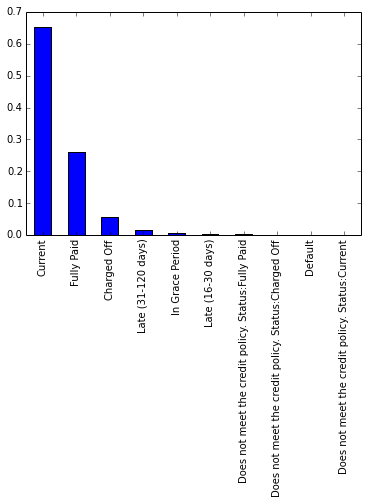

In [112]:
#Plot Loans
loans.loan_status.value_counts(normalize = True).plot(kind = 'bar')

#Given the rarity of the other loan statuses, I plan on comparing Paid vs. Charged-Off loans for capstone project

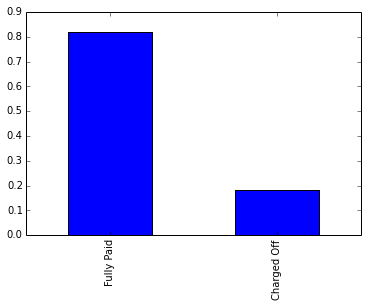

In [113]:
#Filter out everything but paid and charged off and plot
#We're just going to consider those two categories to simplify the analysis
flt_loans = loans[(loans.loan_status == 'Fully Paid') | (loans.loan_status == 'Charged Off')]
flt_loans.loan_status.value_counts(normalize = True).plot(kind = 'bar')

In [114]:
#One feature we can look at is the loan purpose. Some loan types, like debt consolidation, may be quite risky
#whereas others, like home improvement, may be relatively low risk
#Percentages of the different loan purpose values
flt_loans.purpose.value_counts(normalize = True)

debt_consolidation    0.585816
credit_card           0.196911
home_improvement      0.058952
other                 0.056871
major_purchase        0.024982
small_business        0.019146
car                   0.014580
medical               0.011345
moving                0.008074
wedding               0.008024
house                 0.006568
vacation              0.006303
educational           0.001344
renewable_energy      0.001084
dtype: float64

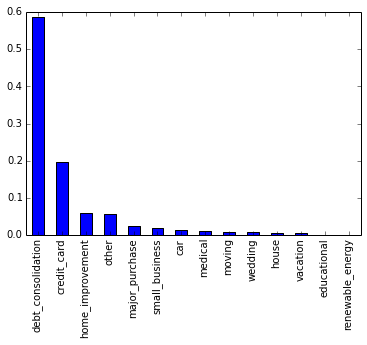

In [115]:
#Plot the percentages of the different loan purpose values
flt_loans.purpose.value_counts(normalize = True).plot(kind = 'bar')

In [117]:
#Check out percentages of paid vs charged off for each type
flt_loans.groupby('purpose').loan_status.value_counts(normalize = True).unstack()

#Categories such as small_business and renewable_energy seem to have particularly high rates of being charged off.
#Small business loans are particularly striking, as they represent ~2% of the data and default at a rate of ~30%
#Some of these categories could be useful features for a model (consider lasso)

,Fully Paid,Charged Off
purpose,,
car,0.875461,0.124539
credit_card,0.841182,0.158818
debt_consolidation,0.811290,0.188710
educational,0.827692,0.172308
home_improvement,0.845085,0.154915
house,0.824937,0.175063
major_purchase,0.858278,0.141722
medical,0.799490,0.200510
moving,0.789447,0.210553


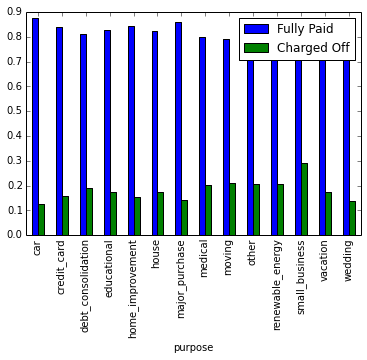

In [118]:
flt_loans.groupby('purpose').loan_status.value_counts(normalize = True).unstack().plot(kind='bar')


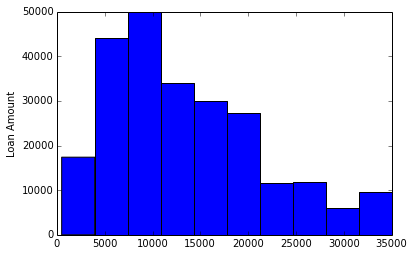

In [119]:
#The loan amount could also be a relevant feature for whether or not a borrower defaults. 
#First lets look at a histogram of the loan amounts
ax = flt_loans.loan_amnt.plot(kind='hist')
ax.set_ylabel("Loan Amount")


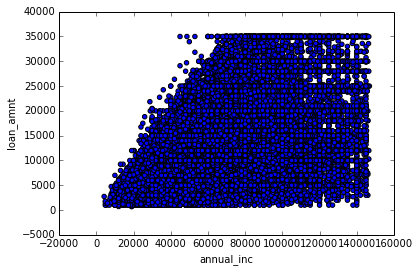

In [120]:
#Loan amounts are probably related to annual income, which could be a good proxy feature for the loan amount.
#This is relevant as the loan amount comes from the Lending Club risk assessment, whereas the annual income is 
#a variable that probably goes into the risk model.
#Scatter plot of loan amount by annual income, ignore top 5% of reported incomes, plotting 25% of the data
flt_loans[flt_loans.annual_inc < flt_loans.annual_inc.quantile(0.95)].sample(frac=0.25).plot(x='annual_inc', y='loan_amnt', kind='scatter')
#It looks like there's a cap at $35,000 and a trend for higher earners to get bigger loans, which makes sense
#as this data only includes funded loans. Annual income may be a good feature for predicting default risk.

In [121]:
#The mean loan size that gets paid off is smaller than the mean loan size that doesn't get paid off
#This might not be a good feature, as it is predicated upon Lending Club's risk assessment
flt_loans.groupby('loan_status').loan_amnt.mean()

loan_status
Charged Off    14534.857999
Fully Paid     13280.400427
Name: loan_amnt, dtype: float64

In [122]:
#The mean borrower income is lower for unpaid than for paid off loans. This on the other hand is probably a 
#good feature for the risk assessment.
flt_loans.groupby('loan_status').annual_inc.mean()

loan_status
Charged Off    65045.280311
Fully Paid     73907.722044
Name: annual_inc, dtype: float64

In [123]:
year_dict = {'emp_length':{'10+ years':10, '< 1 year':0, '3 years':3, '9 years':9, '4 years':4, '5 years':5,
       '1 year':1, '6 years':6, '2 years':2, '7 years':7, '8 years':8, 'n/a':np.nan}}

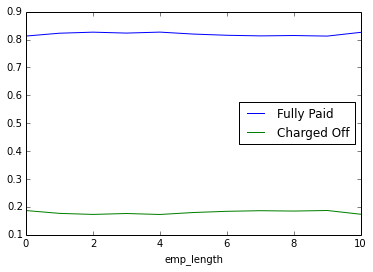

In [124]:
#Another possible feature is the length of employment, but there doesn't seem to be much of an effect here.
flt_loans.replace(year_dict).groupby('emp_length').loan_status.value_counts(normalize=True).unstack().plot()


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


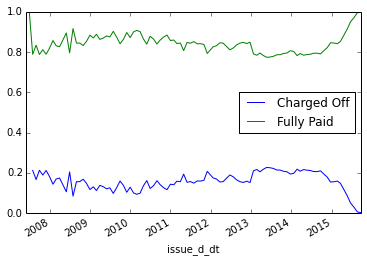

In [126]:
#Another relevant variable for cleaning the data is the issue date on the loan. As we're interested in predicting
#The risk of future loans (potentially), we want to try to avoid contaminating the data with abberations based
#on the business cycle. For example, if there's a spike in defaults in 2008, we might want to ignore that.
#Here, it looks like loans got a bit riskier after 2013, but that could be noise. So it doesn't look like timing is a
#problem. The rates at the tails, then, aren't reliable, as they don't have many observations. There may be a real
#spike in '08, but again, that could be noise.
import datetime as dt
def date_parser(x):
    if isinstance(x, basestring):
        y = dt.datetime.strptime(x,'%b-%Y')
    else:
        y = x
    return y

dates = map(date_parser, flt_loans.issue_d)
flt_loans['issue_d_dt'] = pd.Series(dates,index=flt_loans.index)
flt_loans.groupby('issue_d_dt').loan_status.value_counts(normalize=True).unstack().plot()

So far, it looks like borrower income and the loan purpose are good indicators of risk, whereas the length of employment isn't. These data probably do not need to be filtered based on the issue date, and it is important to be mindful of metrics that are contaminated by the Lending Club's own risk models.

So far, the story seems to be that high incomes make for safer loans and certain loan categories are risky. Small business loans really stood out as a risky proposition and that actually makes a lot of sense. Businesses fail all the time, so debt predicated on the success of a business is riskier debt.

There are many other features that I did not cover here. The debt-to-income ratio, home ownership status, and the history of previous defaults are potentially important features. Additionally, the employer title may be relevant. Unfortunately, there isn't likely to be a lot of data from any one employer, so that might not be helpful. That said, it may be useful to construct new features based on the employer title (e.g., retail, services, etc.) Of course, that requires many assumptions, but they may be useful.

One promising route is to use natural language processing on the loan titles and descriptions provided by the borrower. These descriptions are potentially a rich information source and could yield some promising insights.